# Pré-traitement des données

## Chargement des données

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPooling1D, Bidirectional, Conv1D, concatenate
from keras.models import Model

from tools import *

In [4]:
# load raw string data
data_train, y_train_all, data_test, id_test = load_data()

## Nettoyage des données (optionnel)

In [5]:
params = {'lower': True, 
          'lemma': False, 
          'stop_words': False}

comment = data_train[2]
print(comment)
print('-------')
print(CommentCleaner(**params).transform(comment))

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
-------
Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info 


In [6]:
clean_data_train = transform_dataset(data_train, transformer=CommentCleaner, kwargs=params)
clean_data_test = transform_dataset(data_test, transformer=CommentCleaner, kwargs=params)

Transformation: 100%       
Transformation: 100%       


## Conversion numérique des données textuelles

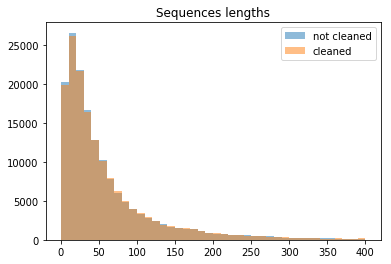

In [7]:
# how to set SENTENCE_LENGTH ?
seq_lengths = [len(comment.split()) for comment in data_train]
cleaned_seq_lengths = [len(comment.split()) for comment in clean_data_train]
hist_bins = np.arange(0, 410, 10)

plt.hist(seq_lengths, bins=hist_bins, alpha=0.5, label='not cleaned')
plt.hist(cleaned_seq_lengths, bins=hist_bins, alpha=0.5, label='cleaned')
# plt.hist([seq_lengths, cleaned_seq_lengths], bins=hist_bins, label=['not cleaned', 'cleaned'])
plt.legend(loc='upper right')
plt.title("Sequences lengths")
plt.show()

In [8]:
# Convert strings to int indexes, 
# considering only the VOCAB_SIZE most common words, 
# and pad the sentences to SENTENCE_LENGTH words
VOCAB_SIZE = 30000
SENTENCE_LENGTH = 200  # 200 if stop_words deleted, 120 otherwise

tokens_vectorizer = TokenVectorizer(max_len=SENTENCE_LENGTH, max_features=VOCAB_SIZE)

# X_train_all, X_test = encode(data_train, data_test, vectorizer=tokens_vectorizer)
X_train_all, X_test = encode(clean_data_train, clean_data_test, vectorizer=tokens_vectorizer)

ENCODING: Fitting vectorizer to data
ENCODING: transforming data to numerical


## Séparation du jeu d'entraînement et de validation

In [9]:
SPLIT_VALID_RATIO = 0.10
SPLIT_RANDOM_SEED = 0  # TODO : check split because of unbalanced classes

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, 
                                                      test_size=SPLIT_VALID_RATIO,
                                                      random_state=SPLIT_RANDOM_SEED)

# Test des différents modèles

## Embeddings + LSTM + 2 fc

In [25]:
EMBEDDING_DIM = 150
TRAIN_EMBEDDINGS = True
MODEL_NAME = "draft_embed_bidirlstm_2fc"

model = bidirectional_lstm(sentence_length=SENTENCE_LENGTH, vocab_size=VOCAB_SIZE,
                    embedding_dim=EMBEDDING_DIM, embedding_matrix=None, train_embeddings=TRAIN_EMBEDDINGS)

In [10]:
# train
BATCH_SIZE = 32
N_EPOCHS = 2

RocAuc = RocAucEvaluation(validation_data=(X_valid, y_valid))

hist = model.fit(X_train, y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=N_EPOCHS, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[RocAuc])

# save trained nnet to disk for later use
save_nnet(model, MODEL_NAME)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1380s 10ms/step - loss: 0.0633 - acc: 0.9789 - val_loss: 0.0469 - val_acc: 0.9826
epoch: 1 - val_roc_auc: 0.9765
Epoch 2/2
143613/143613 [==============================] - 1445s 10ms/step - loss: 0.0432 - acc: 0.9836 - val_loss: 0.0456 - val_acc: 0.9832
epoch: 2 - val_roc_auc: 0.9815


In [11]:
# final model evaluation
y_train_pred = model.predict(X_train, batch_size=512)
train_score = evaluate(y_train, y_train_pred)
print("ROC-AUC score on train set : {:.4f}".format(train_score)) 

y_valid_pred = model.predict(X_valid, batch_size=512)
valid_score = evaluate(y_valid, y_valid_pred)
print("ROC-AUC score on validation set : {:.4f}".format(valid_score))

ROC-AUC score on train set : 0.9898
ROC-AUC score on validation set : 0.9815


In [12]:
# predict
y_test_pred = model.predict(X_test, batch_size=512, verbose=2)

In [13]:
# write submission file
submission(y_test_pred, id_test, name=MODEL_NAME)

## Embeddings + conv1D parallèles + fc (Yoon Kim)

In [10]:
EMBEDDING_DIM = 150
TRAIN_EMBEDDINGS = True
N_FILTERS = 100
FILTERS_SIZES = (3, 5, 7)
MODEL_NAME = "embed_conv_fc"

model = yoon_kim(sentence_length=SENTENCE_LENGTH, vocab_size=VOCAB_SIZE,
                 n_filters=N_FILTERS, filters_sizes=FILTERS_SIZES,
                 embedding_dim=EMBEDDING_DIM, embedding_matrix=None, train_embeddings=TRAIN_EMBEDDINGS)

In [11]:
# train
BATCH_SIZE = 32
N_EPOCHS = 2

RocAuc = RocAucEvaluation(validation_data=(X_valid, y_valid))

hist = model.fit(X_train, y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=N_EPOCHS, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[RocAuc])

# save trained nnet to disk for later use
save_nnet(model, MODEL_NAME)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1145s 8ms/step - loss: 0.0598 - acc: 0.9793 - val_loss: 0.0466 - val_acc: 0.9827
epoch: 1 - val_roc_auc: 0.9800
Epoch 2/2
143613/143613 [==============================] - 1081s 8ms/step - loss: 0.0418 - acc: 0.9838 - val_loss: 0.0441 - val_acc: 0.9836
epoch: 2 - val_roc_auc: 0.9846


FileNotFoundError: [Errno 2] No such file or directory: 'models/embed_conv_fc.json'

In [30]:
# final model evaluation
y_train_pred = model.predict(X_train, batch_size=512)
train_score = evaluate(y_train, y_train_pred)
print("ROC-AUC score on train set : {:.4f}".format(train_score)) 

y_valid_pred = model.predict(X_valid, batch_size=512)
valid_score = evaluate(y_valid, y_valid_pred)
print("ROC-AUC score on validation set : {:.4f}".format(valid_score))

ROC-AUC score on train set : 0.9946
ROC-AUC score on validation set : 0.9852


# Predictions et soumission

In [31]:
# predict
y_test_pred = model.predict(X_test, batch_size=512, verbose=2)

In [32]:
# write submission file
submission(y_test_pred, id_test, name=MODEL_NAME)